# Install required libraries

In [1]:
! pip install -q langgraph langchain-community langchain-core langchain-groq langchain-openai

In [2]:
# Import necessary modules
from google.colab import userdata
import os
from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict
from langgraph.graph import add_messages
from typing import Annotated
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage

from langgraph.graph import START , StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

In [3]:
# Retrieve API keys from Google Colab environment
GROQ_API_KEY = userdata.get('GROQ_API_KEY')
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')

# Set API keys as environment variables
os.environ['GROQ_API_KEY'] = GROQ_API_KEY
os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY

In [4]:
# Initialize language models
llm1 = ChatGroq(model="qwen-2.5-32b")
llm1

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7cedbe663010>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7cedbe68fad0>, model_name='qwen-2.5-32b', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [5]:
# Initialize language models
llm = ChatOpenAI(model="gpt-4o")

In [6]:
# Define mathematical operations
def add(a: int, b: int) -> int:
  """Adds two integers together.

  Args:
    a: The first integer.
    b: The second integer.

  Returns:
    The sum of the two integers.
  """
  return a + b

def multiply(a: int, b: int) -> int:
  """Multiply two integers together.

  Args:
    a: The first integer.
    b: The second integer.

  Returns:
    The multiply of the two integers.
  """
  return a * b

def divide(a: int, b: int) -> float:
  """Divide two integers together.

  Args:
    a: The first integer.
    b: The second integer.

  Returns:
    The divide of the two integers.
  """
  return a / b


In [7]:
# List of available tools (math functions)
tools = [add,multiply,divide]

In [8]:
# Bind tools to the LLM with tool calling disabled in parallel
llm_with_tool_calling = llm.bind_tools(tools,parallel_tool_calls=False)
llm_with_tool_calling

RunnableBinding(bound=ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x7cedbe68fe10>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x7cedbe365f90>, root_client=<openai.OpenAI object at 0x7cedbe593450>, root_async_client=<openai.AsyncOpenAI object at 0x7cedbe355c50>, model_name='gpt-4o', model_kwargs={}, openai_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'add', 'description': 'Adds two integers together.', 'parameters': {'properties': {'a': {'description': 'The first integer.', 'type': 'integer'}, 'b': {'description': 'The second integer.', 'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'multiply', 'description': 'Multiply two integers together.', 'parameters': {'properties': {'a': {'description': 'The first integer.', 'type': 'integer'}, 'b': {'description': 'The second integer.', 'type': 'integer'}}, 'required': ['a', 

In [9]:
# Define a message state for tracking conversation history
class MessageState(TypedDict):
  messages: Annotated[list[AnyMessage],add_messages]

In [10]:
# Define system message for the assistant
system_message = SystemMessage("""
You are a helpful assistant who is tasked with performing arithmetic operation on a set of inputs
""")

# Function to process user messages through the assistant
def assistant(state:MessageState):
  return {"messages":[llm_with_tool_calling.invoke([system_message] + state["messages"])]}

In [11]:
# Create a state graph for managing interactions
builder = StateGraph(MessageState)

# Add nodes to the graph (assistant and tool execution)
builder.add_node("assistant",assistant)
builder.add_node("tools",ToolNode(tools))

# Define the conversation flow
builder.add_edge(START,"assistant")
builder.add_conditional_edges("assistant",tools_condition)
builder.add_edge("tools","assistant")

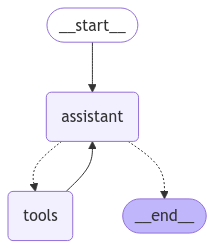

In [12]:
# Compile the graph
graph = builder.compile()
graph

In [13]:
# Example: Invoke the graph with an arithmetic query
messages = graph.invoke({"messages":"2 plus 3 and then multiply by 5 and divide by 2"})
messages

{'messages': [HumanMessage(content='2 plus 3 and then multiply by 5 and divide by 2', additional_kwargs={}, response_metadata={}, id='f8a72476-e7dd-40e8-9c2d-3c2e7f610b36'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_FXnrQKFJ4In3eCQmT6ARTlUa', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'add'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 150, 'total_tokens': 168, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_fee4aaf18f', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-4db84933-4ce8-4bc8-8eec-4d2f7eb7cb95-0', tool_calls=[{'name': 'add', 'args': {'a': 2, 'b': 3}, 'id': 'call_FXnrQKFJ4In3eCQmT6ARTlUa', 'type': 'tool_call'}], usage_metadata={'input_tokens':

In [14]:
for m in messages["messages"]:
  m.pretty_print()

================================ Human Message =================================

2 plus 3 and then multiply by 5 and divide by 2
================================== Ai Message ==================================
Tool Calls:
  add (call_FXnrQKFJ4In3eCQmT6ARTlUa)
 Call ID: call_FXnrQKFJ4In3eCQmT6ARTlUa
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: add

5
================================== Ai Message ==================================
Tool Calls:
  multiply (call_ljFTWh4vrzvR1ryTTHqIXagx)
 Call ID: call_ljFTWh4vrzvR1ryTTHqIXagx
  Args:
    a: 5
    b: 5
================================= Tool Message =================================
Name: multiply

25
================================== Ai Message ==================================
Tool Calls:
  divide (call_S9XgEnIXDNNXN22MtTQFBSz9)
 Call ID: call_S9XgEnIXDNNXN22MtTQFBSz9
  Args:
    a: 25
    b: 2
================================= Tool Message =============================

# Memory Using MemorySaver

In [15]:
from langgraph.checkpoint.memory import MemorySaver

In [16]:
# Test case without memory
messages = graph.invoke({"messages":"add 14 plus 15"})
for m in messages["messages"]:
  m.pretty_print()

================================ Human Message =================================

add 14 plus 15
================================== Ai Message ==================================
Tool Calls:
  add (call_JTh7wr5TcRvl5yfjkqIRxQ9n)
 Call ID: call_JTh7wr5TcRvl5yfjkqIRxQ9n
  Args:
    a: 14
    b: 15
================================= Tool Message =================================
Name: add

29
================================== Ai Message ==================================

14 plus 15 is 29.


In [17]:
messages = graph.invoke({"messages":"multiply by 2"})
for m in messages["messages"]:
  m.pretty_print()

================================ Human Message =================================

multiply by 2
================================== Ai Message ==================================

It seems like you would like to multiply a number by 2, but you haven't specified the number. Please provide the number you'd like to multiply by 2.


In [18]:
# Enable memory for state retention
memory = MemorySaver()

graph = builder.compile(checkpointer=memory)

In [19]:
# Use thread IDs to track conversations
config = {"thread_id":"1"}

messages = graph.invoke({"messages":"add 14 plus 15"},config=config)
for m in messages["messages"]:
  m.pretty_print()

================================ Human Message =================================

add 14 plus 15
================================== Ai Message ==================================
Tool Calls:
  add (call_832A4qFGmqNSk6Hb0YeCFXv7)
 Call ID: call_832A4qFGmqNSk6Hb0YeCFXv7
  Args:
    a: 14
    b: 15
================================= Tool Message =================================
Name: add

29
================================== Ai Message ==================================

14 plus 15 equals 29.


In [20]:
messages = graph.invoke({"messages":"Multiply by 2"},config=config)
for m in messages["messages"]:
  m.pretty_print()

================================ Human Message =================================

add 14 plus 15
================================== Ai Message ==================================
Tool Calls:
  add (call_832A4qFGmqNSk6Hb0YeCFXv7)
 Call ID: call_832A4qFGmqNSk6Hb0YeCFXv7
  Args:
    a: 14
    b: 15
================================= Tool Message =================================
Name: add

29
================================== Ai Message ==================================

14 plus 15 equals 29.
================================ Human Message =================================

Multiply by 2
================================== Ai Message ==================================
Tool Calls:
  multiply (call_dB6GJcjrknp09oUNIpsOnNG4)
 Call ID: call_dB6GJcjrknp09oUNIpsOnNG4
  Args:
    a: 29
    b: 2
================================= Tool Message =================================
Name: multiply

58
================================== Ai Message ==================================

Multiplying 29 by 2 give

In [21]:
# Second thread (new conversation)
config = {"thread_id":"2"}

messages = graph.invoke({"messages":"add 14 to it"},config=config)
for m in messages["messages"]:
  m.pretty_print()

================================ Human Message =================================

add 14 to it
================================== Ai Message ==================================

It seems like you are referring to a preceding number with "it." Could you please provide the number you'd like to add 14 to?
